<a href="https://colab.research.google.com/github/carlm451/Gemstone_Images_Classification_Fine_Tuning/blob/main/Gemstones_Classifier_Model_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import os
import matplotlib.pyplot as plt
from random import shuffle 

In [3]:
# pulling gemstones data from kaggle
!pip install kaggle

!mkdir ~/.kaggle

!mv kaggle.json ~/.kaggle

! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory


In [4]:
!ls ~/.kaggle

kaggle.json


In [5]:
!kaggle datasets download lsind18/gemstones-images

100% 55.0M/55.2M [00:03<00:00, 18.2MB/s]
100% 55.2M/55.2M [00:03<00:00, 16.3MB/s]


In [7]:
!unzip gemstones-images.zip

Archive:  gemstones-images.zip
  inflating: test/Alexandrite/alexandrite_18.jpg  
  inflating: test/Alexandrite/alexandrite_28.jpg  
  inflating: test/Alexandrite/alexandrite_3.jpg  
  inflating: test/Alexandrite/alexandrite_6.jpg  
  inflating: test/Almandine/almandine_18.jpg  
  inflating: test/Almandine/almandine_28.jpg  
  inflating: test/Almandine/almandine_3.jpg  
  inflating: test/Almandine/almandine_9.jpg  
  inflating: test/Amazonite/amazonite_18.jpg  
  inflating: test/Amazonite/amazonite_28.jpg  
  inflating: test/Amazonite/amazonite_3.jpg  
  inflating: test/Amazonite/amazonite_8.jpg  
  inflating: test/Amber/amber_18.jpg  
  inflating: test/Amber/amber_28.jpg  
  inflating: test/Amber/amber_3.jpg  
  inflating: test/Amber/amber_9.jpg  
  inflating: test/Amethyst/amethyst_18.jpg  
  inflating: test/Amethyst/amethyst_3.jpg  
  inflating: test/Amethyst/amethyst_5.jpg  
  inflating: test/Amethyst/amethyst_7.jpg  
  inflating: test/Ametrine/ametrine_18.jpg  
  inflating: test/A

In [9]:
!mkdir

/content


In [11]:
import os

data_dir = '/content'

train_dir = os.path.join(data_dir,'train')

val_dir = os.path.join(data_dir,'val')

test_dir = os.path.join(data_dir,'test')

def count_img_samples(directory):
    
    count = 0
    
    for i,gem_type in enumerate(os.listdir(directory)):
        
        gem_dir = os.path.join(directory,gem_type)
    
        img_list = os.listdir(gem_dir)

        #print(f' dir {gem_dir} has {len(img_list)} images')

        count += len(img_list)
    
    return count

n_train = count_img_samples(train_dir)
n_test = count_img_samples(test_dir)
n_val = count_img_samples(val_dir)

print(f'{n_train=}, {n_val=}, {n_test=}')

mkdir: cannot create directory ‘val’: File exists
n_train=2856, n_val=0, n_test=363


In [14]:
from random import shuffle

def partition_val_data(train_dir,val_dir,val_split=0.1):
    
    for gem_type in os.listdir(train_dir):
        
        train_gem_dir = os.path.join(train_dir,gem_type)
        
        img_list = os.listdir(train_gem_dir)
        
        shuffle(img_list)
        
        n_samples = round(len(img_list)*val_split)
        
        val_img_list = img_list[:n_samples] # take n_samples random images to move
        
        val_gem_dir = os.path.join(val_dir,gem_type)
        
        if not os.path.exists(val_gem_dir):
            
            os.mkdir(val_gem_dir)
            
            for gem_img in val_img_list:
                
                original_path = os.path.join(train_gem_dir,gem_img)
                
                destination_path = os.path.join(val_gem_dir,gem_img)
                
                os.rename(original_path,destination_path)
        
            print(f'Moved {len(os.listdir(val_gem_dir))} training images from to {val_gem_dir}')
            
        else:
            
            print(f'Val dir {val_gem_dir} has {len(os.listdir(val_gem_dir))} images')

In [15]:
val_split=0.15  # move 15% train to use for validation

partition_val_data(train_dir,val_dir,val_split)

Moved 4 training images from to /content/val/Onyx Red
Moved 5 training images from to /content/val/Alexandrite
Moved 5 training images from to /content/val/Quartz Rose
Moved 5 training images from to /content/val/Quartz Lemon
Moved 5 training images from to /content/val/Almandine
Moved 6 training images from to /content/val/Peridot
Moved 5 training images from to /content/val/Diaspore
Moved 4 training images from to /content/val/Serpentine
Moved 6 training images from to /content/val/Quartz Rutilated
Moved 5 training images from to /content/val/Spodumene
Moved 4 training images from to /content/val/Chrysoprase
Moved 5 training images from to /content/val/Morganite
Moved 5 training images from to /content/val/Opal
Moved 5 training images from to /content/val/Emerald
Moved 5 training images from to /content/val/Garnet Red
Moved 4 training images from to /content/val/Zoisite
Moved 5 training images from to /content/val/Diamond
Moved 4 training images from to /content/val/Onyx Black
Moved 

In [18]:
!ls val

gem_types_list = os.listdir(val_dir)

n_classes = len(gem_types_list)

print(f'{n_classes} classes of gemstone')

 Alexandrite	      Chrysocolla     Larimar		 'Sapphire Blue'
 Almandine	      Chrysoprase     Malachite		 'Sapphire Pink'
 Amazonite	      Citrine	      Moonstone		 'Sapphire Purple'
 Amber		      Coral	      Morganite		 'Sapphire Yellow'
 Amethyst	      Danburite      'Onyx Black'	  Scapolite
 Ametrine	      Diamond	     'Onyx Green'	  Serpentine
 Andalusite	      Diaspore	     'Onyx Red'		  Sodalite
 Andradite	      Dumortierite    Opal		  Spessartite
 Aquamarine	      Emerald	      Pearl		  Sphene
'Aventurine Green'    Fluorite	      Peridot		  Spinel
'Aventurine Yellow'  'Garnet Red'     Prehnite		  Spodumene
 Benitoite	      Goshenite       Pyrite		  Sunstone
'Beryl Golden'	      Grossular       Pyrope		  Tanzanite
 Bixbite	      Hessonite      'Quartz Beer'	 'Tigers Eye'
 Bloodstone	      Hiddenite      'Quartz Lemon'	  Topaz
'Blue Lace Agate'     Iolite	     'Quartz Rose'	  Tourmaline
 Carnelian	      Jade	     'Quartz Rutilated'   Tsavorite
'Cats Eye'	      Jasper	     'Quartz 

In [61]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

mobilenet_V2_pretrained = MobileNetV2(include_top=False, pooling='avg',input_shape=(224,224,3))

for layer in mobilenet_V2_pretrained.layers:
    layer.trainable=False

mobilenet_V2_pretrained.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [20]:
import numpy as np

from tensorflow.keras.utils import load_img, img_to_array

def get_img_array(directory,gem_type):
    
    gem_dir = os.path.join(directory,gem_type)
    
    img_list = os.listdir(gem_dir)
    
    #shuffle(img_list)
    
    img_path = os.path.join(gem_dir,img_list[0])
    
    img = load_img(img_path)
    
    x = img_to_array(img) / 255.
    
    return x

def get_img_array_resized(directory,gem_type):
    
    gem_dir = os.path.join(directory,gem_type)
    
    img_list = os.listdir(gem_dir)
    
    #shuffle(img_list)
    
    img_path = os.path.join(gem_dir,img_list[0])
    
    img = load_img(img_path,target_size=(224,224),keep_aspect_ratio=True)
    
    x = img_to_array(img) / 255.
    
    return x

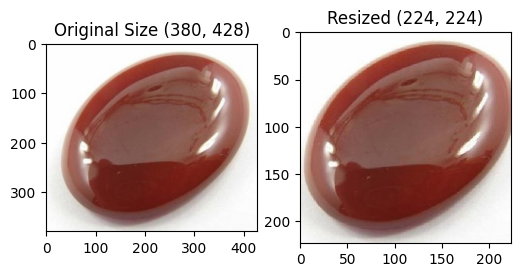

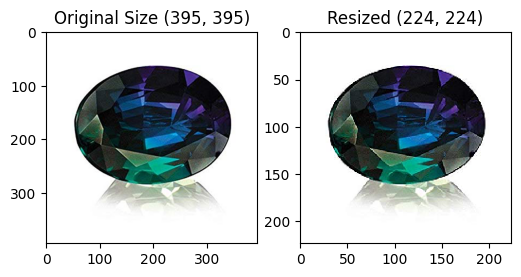

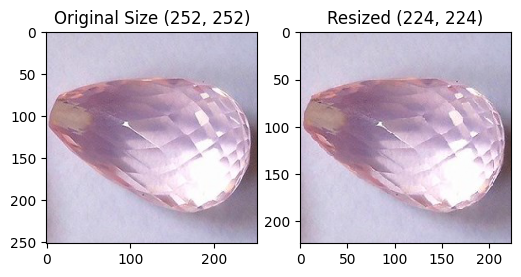

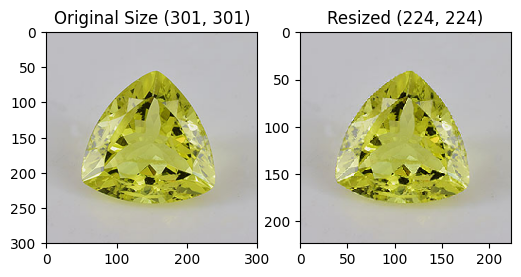

In [21]:
import matplotlib.pyplot as plt

for gem_type in gem_types_list[:4]:

    sample_x = get_img_array(train_dir,gem_type)

    sample_x_resized = get_img_array_resized(train_dir,gem_type)

    fix, (ax1,ax2) =plt.subplots(1,2,figsize=(6,6))

    ax1.imshow(sample_x)
    ax1.set_title(f'Original Size {sample_x.shape[:2]}')

    ax2.imshow(sample_x_resized)
    ax2.set_title(f'Resized {sample_x_resized.shape[:2]}')

    plt.show()

In [62]:
# generators to stream images for training/validation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                   rotation_range=90,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   zoom_range=0.4,
                                   horizontal_flip=True,
                                   vertical_flip=True
                                  )

val_datagen  = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(224, 224),
                                                    keep_aspect_ratio='True',
                                                    classes=gem_types_list) 

val_generator = val_datagen.flow_from_directory(val_dir,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(224,224),
                                                    keep_aspect_ratio='True',
                                                    classes=gem_types_list) 

Found 2434 images belonging to 87 classes.
Found 422 images belonging to 87 classes.


In [63]:
def get_uncompiled_model(n_classes, pre_trained_model, model_name):

    model = tf.keras.models.Sequential(name=model_name)
    model.add(pre_trained_model)
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [64]:
model = get_uncompiled_model(n_classes,mobilenet_V2_pretrained,'mobilenet_base_1')
    
model.summary()

model.input

Model: "mobilenet_base_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 87)                111447    
                                                                 
Total params: 2,369,431
Trainable params: 111,447
Non-trainable params: 2,257,984
_________________________________________________________________


<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'mobilenetv2_1.00_224_input')>

In [65]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [66]:
!mkdir training_1

mkdir: cannot create directory ‘training_1’: File exists


In [67]:
checkpoint_path = "training_1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq='epoch')

history = model.fit(
            train_generator,
            epochs=8,
            validation_data=val_generator,
            verbose=1,
            callbacks=[cp_callback]
            )

Epoch 1/8
77/77 [==============================] - ETA: 0s - loss: 4.4846 - categorical_accuracy: 0.2683
Epoch 1: saving model to training_1/cp-0001.ckpt
77/77 [==============================] - 40s 479ms/step - loss: 4.4846 - categorical_accuracy: 0.2683 - val_loss: 3.2363 - val_categorical_accuracy: 0.3957
Epoch 2/8
77/77 [==============================] - ETA: 0s - loss: 2.9690 - categorical_accuracy: 0.4519
Epoch 2: saving model to training_1/cp-0002.ckpt
77/77 [==============================] - 34s 443ms/step - loss: 2.9690 - categorical_accuracy: 0.4519 - val_loss: 2.6692 - val_categorical_accuracy: 0.4763
Epoch 3/8
77/77 [==============================] - ETA: 0s - loss: 2.4921 - categorical_accuracy: 0.5152
Epoch 3: saving model to training_1/cp-0003.ckpt
77/77 [==============================] - 33s 429ms/step - loss: 2.4921 - categorical_accuracy: 0.5152 - val_loss: 2.9654 - val_categorical_accuracy: 0.5071
Epoch 4/8
76/77 [============================>.] - ETA: 0s - loss: 2.5

Text(0.5, 1.0, 'Training and validation loss')

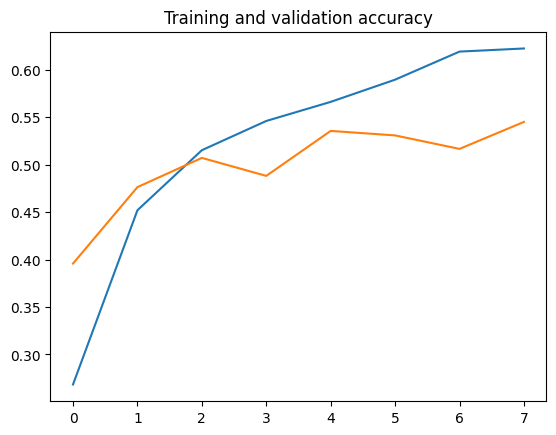

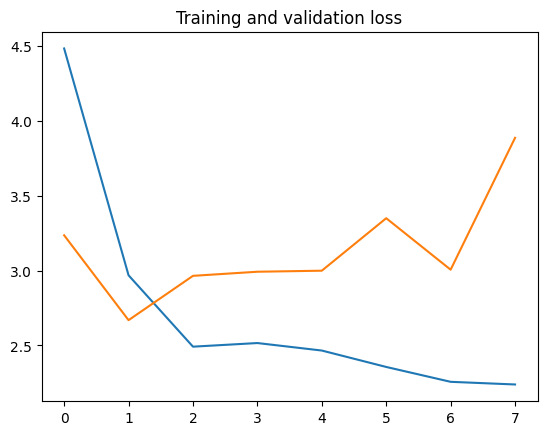

In [68]:
acc      = history.history[     'categorical_accuracy' ]
val_acc  = history.history[ 'val_categorical_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [69]:
os.listdir(checkpoint_dir)

['cp-0006.ckpt.index',
 'cp-0005.ckpt.index',
 'cp-0003.ckpt.data-00000-of-00001',
 'cp-0002.ckpt.index',
 'cp-0008.ckpt.data-00000-of-00001',
 'cp-0004.ckpt.index',
 'cp-0002.ckpt.data-00000-of-00001',
 'cp-0005.ckpt.data-00000-of-00001',
 'cp-0001.ckpt.index',
 'cp-0003.ckpt.index',
 'checkpoint',
 'cp-0001.ckpt.data-00000-of-00001',
 'cp-0007.ckpt.index',
 'cp-0004.ckpt.data-00000-of-00001',
 'cp-0008.ckpt.index',
 'cp-0006.ckpt.data-00000-of-00001',
 'cp-0007.ckpt.data-00000-of-00001']

In [70]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'training_1/cp-0008.ckpt'

In [73]:
mobilenet_V2_trainable = MobileNetV2(include_top=False, pooling='avg',input_shape=(224,224,3))

n_layers = len(mobilenet_V2_trainable.layers)

n_freeze = round(0.8*n_layers)

for layer in mobilenet_V2_trainable.layers[:n_freeze]:
    layer.trainable=False

mobilenet_V2_trainable.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [74]:
model_finetune = get_uncompiled_model(n_classes,mobilenet_V2_trainable,'mobilenet_finetune')
    
model_finetune.summary()

model_finetune.input

Model: "mobilenet_finetune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 87)                111447    
                                                                 
Total params: 2,369,431
Trainable params: 1,637,847
Non-trainable params: 731,584
_________________________________________________________________


<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'mobilenetv2_1.00_224_input')>

In [75]:
!mkdir training_2

In [77]:
model_finetune.load_weights(latest)

model_finetune.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [78]:
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq='epoch')

history_finetune = model_finetune.fit(
            train_generator,
            epochs=8,
            validation_data=val_generator,
            verbose=1,
            callbacks=[cp_callback]
            )

Epoch 1/8
77/77 [==============================] - ETA: 0s - loss: 3.0599 - categorical_accuracy: 0.5296
Epoch 1: saving model to training_2/cp-0001.ckpt
77/77 [==============================] - 43s 445ms/step - loss: 3.0599 - categorical_accuracy: 0.5296 - val_loss: 5.8975 - val_categorical_accuracy: 0.4313
Epoch 2/8
77/77 [==============================] - ETA: 0s - loss: 1.4727 - categorical_accuracy: 0.6343
Epoch 2: saving model to training_2/cp-0002.ckpt
77/77 [==============================] - 35s 459ms/step - loss: 1.4727 - categorical_accuracy: 0.6343 - val_loss: 5.4815 - val_categorical_accuracy: 0.4692
Epoch 3/8
77/77 [==============================] - ETA: 0s - loss: 1.2030 - categorical_accuracy: 0.6808
Epoch 3: saving model to training_2/cp-0003.ckpt
77/77 [==============================] - 34s 450ms/step - loss: 1.2030 - categorical_accuracy: 0.6808 - val_loss: 4.7297 - val_categorical_accuracy: 0.5000
Epoch 4/8
77/77 [==============================] - ETA: 0s - loss: 1.0

Text(0.5, 1.0, 'Training and validation loss')

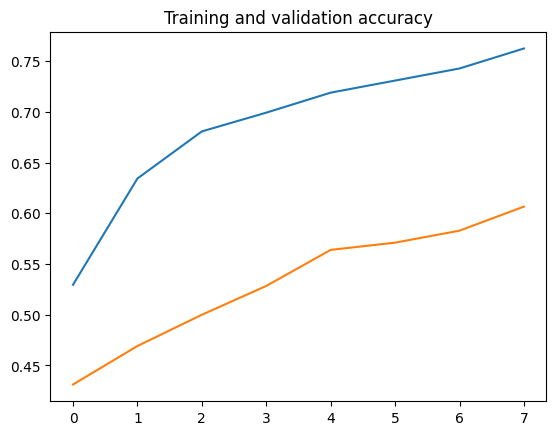

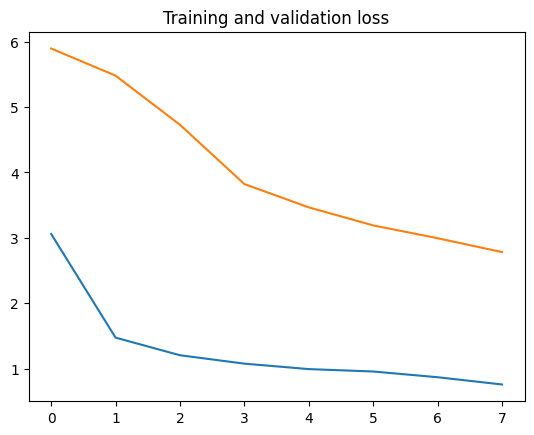

In [79]:
acc      = history_finetune.history['categorical_accuracy' ]
val_acc  = history_finetune.history['val_categorical_accuracy' ]
loss     = history_finetune.history['loss' ]
val_loss = history_finetune.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )